# DPGExplainer Saga Benchmarks — Episode 1: Iris

A practitioner-friendly walkthrough of Decision Predicate Graphs (DPG) using the classic Iris dataset. We train a small Random Forest (RF), build a DPG to map the model’s global behavior using Explainable AI (XAI), and interpret three key properties to explain the model: Local Reaching Centrality (LRC), Betweenness Centrality (BC), and node communities.


## 1. What is Explainable AI (XAI)
Explainable AI (XAI) focuses on making model behavior understandable to people. It helps answer questions like why a prediction was made, what features mattered most, and whether the model behaves as intended.

Common motivations for XAI include:
- Explain to justify: Provide evidence for decisions in high-stakes contexts.
- Explain to discover: Surface patterns, biases, or unexpected signals in the data.
- Explain to improve: Debug models, features, and data issues.
- Explain to control: Support monitoring, governance, and compliance.

XAI methods are often grouped into:
- Global explanations: Summarize how the model behaves overall.
- Local explanations: Explain a single prediction or a small region of the feature space.

SHAP is a popular local method, while DPG provides a global view by turning an ensemble into a predicate graph and analyzing its structure.


## 2. Why DPG (in one minute)
Tree ensembles, such as RF, can be accurate but hard to interpret globally. DPG converts the ensemble into a graph where:
- Nodes are predicates like `petal length <= 2.45`, in the iris case.
- Edges capture how often training samples traverse those predicates
- Metrics quantify how predicates structure the model’s global reasoning

This gives a global map of decision logic and allows the use of graph metrics to capture the model’s rationale.

In the next steps, we create a Random Forest model of the Iris dataset and explain it with DPG.


## 3. Setup (Iris + Random Forest + DPG)

We first train a baseline Random Forest, then inspect pairwise feature/class structure with a pair plot.


In [100]:
%pip install --force-reinstall --no-deps git+https://github.com/Meta-Group/DPG.git

  Cloning https://github.com/Meta-Group/DPG.git to /private/var/folders/gc/mhnpykzn5n15__6zh66dkf6r0000gn/T/pip-req-build-ggrigx9j
  Running command git clone --filter=blob:none --quiet https://github.com/Meta-Group/DPG.git /private/var/folders/gc/mhnpykzn5n15__6zh66dkf6r0000gn/T/pip-req-build-ggrigx9j
  Resolved https://github.com/Meta-Group/DPG.git to commit 8ce9f7194e535ecc47777d8e7dc5d91e8b0daba0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dpg: filename=dpg-0.1.5-py3-none-any.whl size=30321 sha256=91f016f18f626d19451b83a2590e3f6249733ec57e601bf40a68c33e27c27491
  Stored in directory: /private/var/folders/gc/mhnpykzn5n15__6zh66dkf6r0000gn/T/pip-ephem-wheel-cache-wbx4d_io/wheels/dc/1b/f7/79000c8935cb0c07cc77c2dd6e4931f0bc0ff84c354271fdbc
Successfully built dpg
  Attempting uninstall: dpg
    Found existing installation: dpg 0.1.5
    Uninstalling dpg-0.1.5:
      Successfull

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.77      1.00      0.87        10
   virginica       1.00      0.70      0.82        10

    accuracy                           0.90        30
   macro avg       0.92      0.90      0.90        30
weighted avg       0.92      0.90      0.90        30



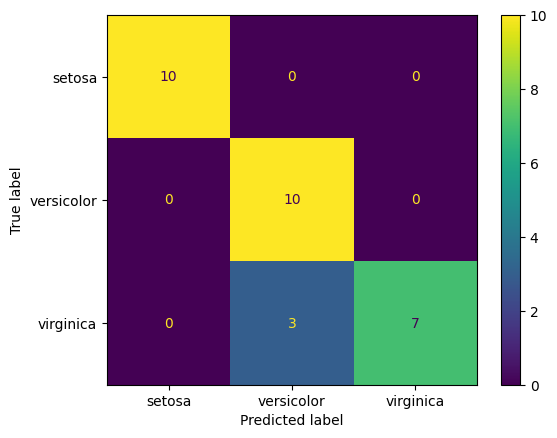

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from dpg import DPGExplainer

iris = load_iris(as_frame=True)
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(n_estimators=10, random_state=27)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=iris.target_names).plot()
print(classification_report(y_test, y_pred, target_names=iris.target_names))


### 3.1 Pair Plot (All Features by Class)


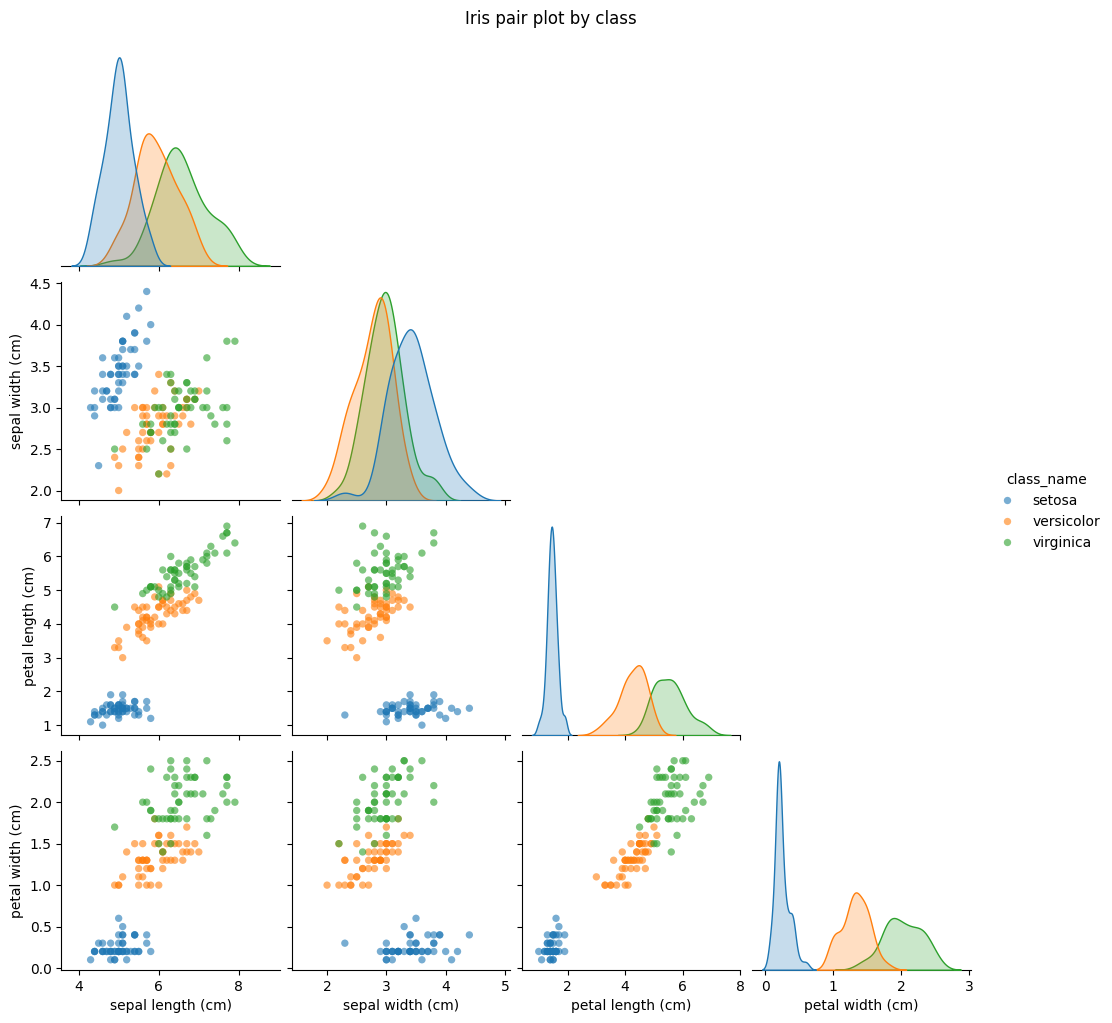

In [102]:
import seaborn as sns

pair_df = X.copy()
pair_df["class_name"] = y.map(lambda i: iris.target_names[i])

sns.pairplot(
    pair_df,
    hue="class_name",
    diag_kind="kde",
    corner=True,
    plot_kws={"alpha": 0.6, "s": 28, "edgecolor": "none"},
)
plt.suptitle("Iris pair plot by class", y=1.02)
plt.show()



## 4. Extracting DPG from RF

Next, we extract the DPG from our RF model. The parameters `feature_names` and `target_names` provide readable output for the mapped scenarios.


In [103]:
explainer = DPGExplainer(
    model=model,
    feature_names=X.columns,
    target_names=iris.target_names.tolist(),
    config_file="config.yaml",  # optional if present
)

explanation = explainer.explain_global(
    X.values,
    communities=True,
    community_threshold=0.2,
)


Config file not found at 'config.yaml'. Using built-in defaults.
DPG initialized with perc_var=1e-09, decimal_threshold=6, n_jobs=-1

Starting DPG extraction *****************************************
Model Class: RandomForestClassifier
Model Class Module: sklearn.ensemble._forest
Model Estimators:  10
Model Params:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 27, 'verbose': 0, 'warm_start': False}
*****************************************************************


100%|██████████| 150/150 [00:00<00:00, 4372.92it/s]


Total of paths: 1500
Building DPG...


Processing cases: 100%|██████████| 1500/1500 [00:00<00:00, 33291.12it/s]

Extracting graph...



/Users/barbon/Python/DPG/.venv/lib/python3.11/site-packages/metrics/graph.py:246: RuntimeWarning: divide by zero encountered in matmul
  B = N @ R
/Users/barbon/Python/DPG/.venv/lib/python3.11/site-packages/metrics/graph.py:246: RuntimeWarning: overflow encountered in matmul
  B = N @ R
/Users/barbon/Python/DPG/.venv/lib/python3.11/site-packages/metrics/graph.py:246: RuntimeWarning: invalid value encountered in matmul
  B = N @ R


## 5. Read the DPG Metrics


In [104]:
explanation.node_metrics.head()


,Node,Degree,In degree nodes,Out degree nodes,Betweenness centrality,Local reaching centrality,Label
0,947984079661264961342870691539136022574948430341,9,4,5,0.025235,0.493532,petal width (cm) > 1.75
1,932937007815942507434825409649584455941241883029,2,1,1,0.001695,0.000618,sepal width (cm) > 3.1
2,1130721551439099696578385742755576245540083153693,22,22,0,0.000000,0.000000,Class versicolor
3,61544206146760529155073786406784489822135270333,8,3,5,0.088795,0.498224,sepal length (cm) <= 5.95
4,573585474223013620077006769186407898848307322087,6,3,3,0.056309,0.417789,petal length (cm) <= 4.85


**Local Reaching Centrality (LRC)**
- High LRC nodes can reach many other nodes downstream.
- These predicates often act early, framing large portions of the model’s logic.

**Betweenness Centrality (BC)**
- High BC nodes lie on many shortest paths between other nodes.
- These predicates are “bottlenecks” that connect major decision flows.


## 6. Compare Top LRC Predicates vs Random Forest Importance


/var/folders/gc/mhnpykzn5n15__6zh66dkf6r0000gn/T/ipykernel_57728/2852814865.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  nm = nm[nm["Label"].str.contains(r"(<=|>)", regex=True, na=False)].copy()


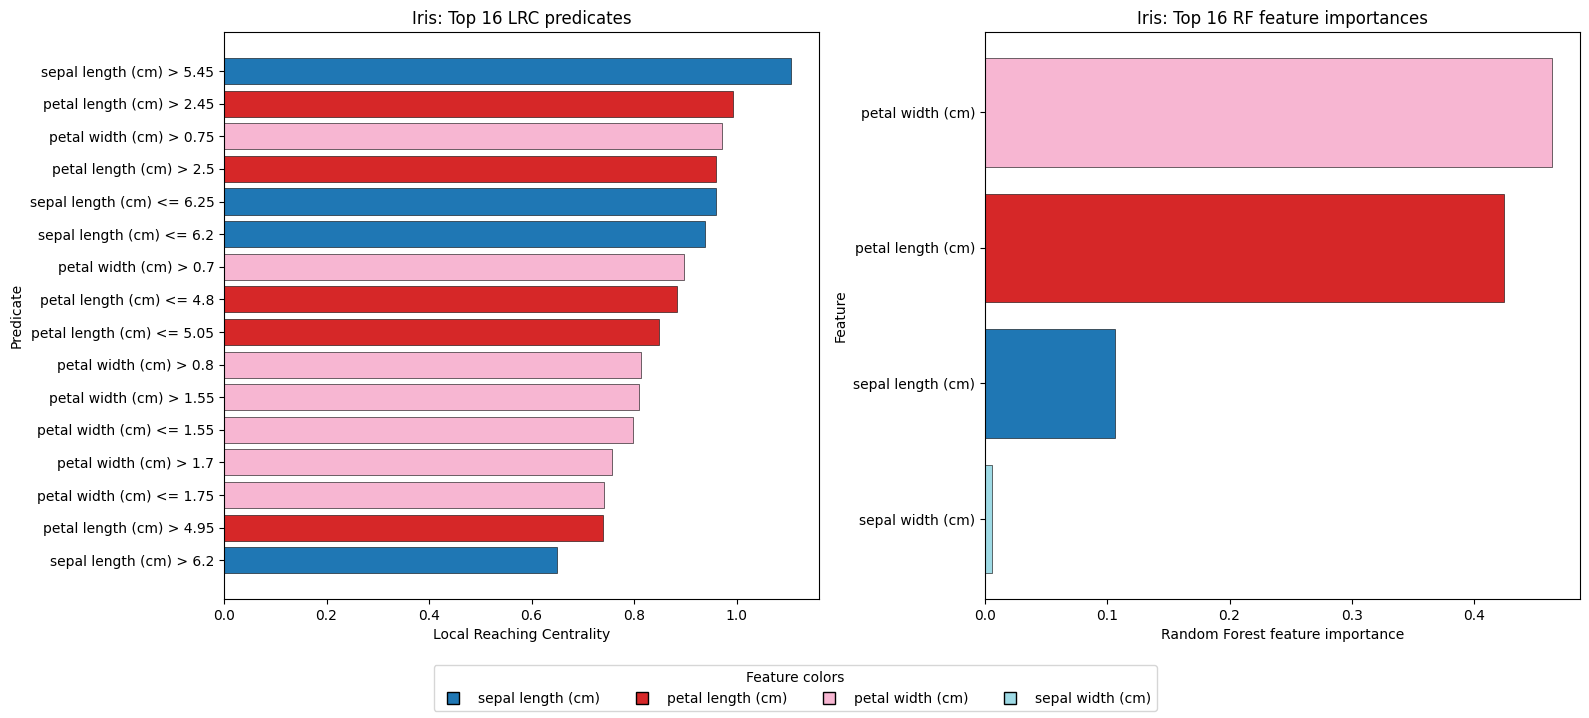

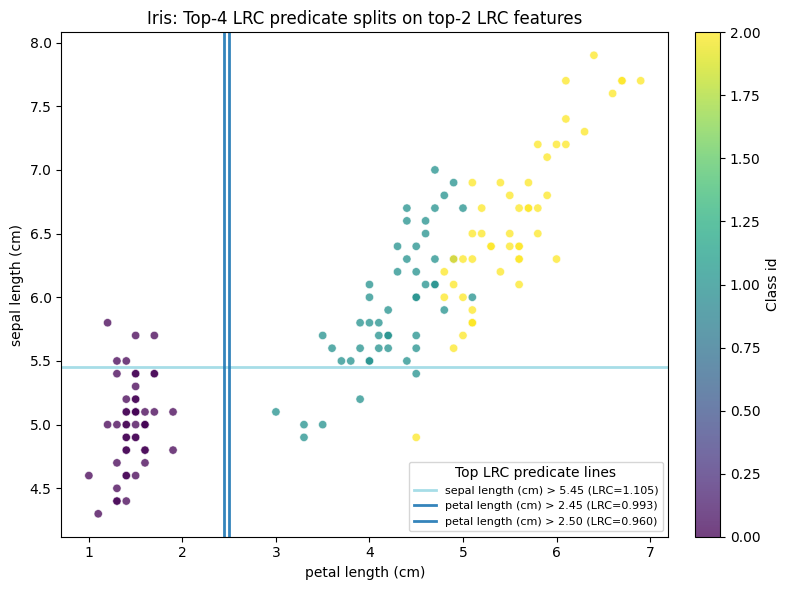

In [105]:
import matplotlib.pyplot as plt
import re

def parse_predicate_parts(label: str):
    m = re.search(r"(.+?)\s*(<=|>)\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", str(label))
    if not m:
        return None
    feature = m.group(1).strip()
    op = m.group(2)
    threshold = float(m.group(3))
    return feature, op, threshold


def parse_feature_from_predicate(label: str) -> str:
    parts = parse_predicate_parts(label)
    return parts[0] if parts else str(label)


def lrc_predicate_scores(explanation, top_k=10):
    nm = explanation.node_metrics.copy()
    nm = nm[nm["Label"].str.contains(r"(<=|>)", regex=True, na=False)].copy()
    nm = nm.sort_values("Local reaching centrality", ascending=False).head(top_k)

    rows = []
    for _, r in nm.iterrows():
        parsed = parse_predicate_parts(r["Label"])
        if not parsed:
            continue
        feature, op, threshold = parsed
        rows.append({
            "predicate": str(r["Label"]),
            "feature": feature,
            "op": op,
            "threshold": threshold,
            "lrc": float(r["Local reaching centrality"]),
        })

    return pd.DataFrame(rows)


def _feature_color_map(features):
    unique = list(dict.fromkeys(features))
    cmap = plt.cm.tab20
    if len(unique) <= 1:
        return {unique[0]: cmap(0)} if unique else {}
    return {f: cmap(i / (len(unique) - 1)) for i, f in enumerate(unique)}


def plot_lrc_vs_rf_importance(explanation, model, X_df, top_k=10, dataset_name='Iris'):
    top_lrc = lrc_predicate_scores(explanation, top_k=top_k).copy()

    top_rf = (
        pd.DataFrame({
            "feature": list(getattr(model, "feature_names_in_", X_df.columns)),
            "rf_importance": model.feature_importances_.astype(float),
        })
        .sort_values("rf_importance", ascending=False)
        .head(top_k)
    )

    # Sort ascending for readable horizontal bars
    top_lrc_plot = top_lrc.sort_values("lrc", ascending=True)
    top_rf_plot = top_rf.sort_values("rf_importance", ascending=True)

    # Keep feature colors consistent across both plots
    all_features = top_lrc_plot["feature"].tolist() + top_rf_plot["feature"].tolist()
    feature_to_color = _feature_color_map(all_features)

    fig, axes = plt.subplots(1, 2, figsize=(16, max(5, top_k * 0.45)))

    axes[0].barh(
        top_lrc_plot["predicate"],
        top_lrc_plot["lrc"],
        color=[feature_to_color[f] for f in top_lrc_plot["feature"]],
        edgecolor="black",
        linewidth=0.4,
    )
    axes[0].set_title(f"{dataset_name}: Top {top_k} LRC predicates")
    axes[0].set_xlabel("Local Reaching Centrality")
    axes[0].set_ylabel("Predicate")

    axes[1].barh(
        top_rf_plot["feature"],
        top_rf_plot["rf_importance"],
        color=[feature_to_color[f] for f in top_rf_plot["feature"]],
        edgecolor="black",
        linewidth=0.4,
    )
    axes[1].set_title(f"{dataset_name}: Top {top_k} RF feature importances")
    axes[1].set_xlabel("Random Forest feature importance")
    axes[1].set_ylabel("Feature")

    legend_features = list(dict.fromkeys(all_features))
    legend_handles = [
        plt.Line2D([0], [0], marker='s', color='w', label=f,
                   markerfacecolor=feature_to_color[f], markeredgecolor='black', markersize=8)
        for f in legend_features
    ]
    fig.legend(handles=legend_handles, title="Feature colors",
               loc="lower center", ncol=min(4, max(1, len(legend_handles))), frameon=True)

    plt.tight_layout(rect=(0, 0.08, 1, 1))
    plt.show()


def plot_top_lrc_predicate_splits(explanation, X_df, y, top_predicates=5, top_features=2, dataset_name='Iris'):
    top_lrc = lrc_predicate_scores(explanation, top_k=max(top_predicates, 10)).copy()
    top5 = top_lrc.sort_values("lrc", ascending=False).head(top_predicates).copy()

    # Select top-2 LRC features using cumulative LRC contribution
    feature_rank = (
        top_lrc.groupby("feature", as_index=False)["lrc"].sum()
        .sort_values("lrc", ascending=False)
        .head(top_features)
    )
    selected_features = feature_rank["feature"].tolist()
    if len(selected_features) < 2:
        print(f"{dataset_name}: not enough LRC features to build a 2D split plot.")
        return

    fx, fy = selected_features[0], selected_features[1]
    if fx not in X_df.columns or fy not in X_df.columns:
        print(f"{dataset_name}: selected LRC features not present in input dataframe columns.")
        return

    # Lines from top-5 predicates only, restricted to top-2 selected features
    split_rows = top5[top5["feature"].isin([fx, fy])].copy()

    fig, ax = plt.subplots(figsize=(8, 6))

    sc = ax.scatter(
        X_df[fx],
        X_df[fy],
        c=y,
        cmap='viridis',
        s=36,
        alpha=0.75,
        edgecolor='white',
        linewidth=0.5,
    )

    # Color by feature to keep consistency with section colors
    feature_to_color = _feature_color_map([fx, fy])

    line_labels_seen = set()
    for _, r in split_rows.iterrows():
        f, op, thr, score = r["feature"], r["op"], r["threshold"], r["lrc"]
        if f == fx:
            ls = '--' if op == '<=' else '-'
            label = f"{f} {op} {thr:.2f} (LRC={score:.3f})"
            ax.axvline(
                thr,
                color=feature_to_color[f],
                linestyle=ls,
                linewidth=2,
                alpha=0.9,
                label=label if label not in line_labels_seen else None,
            )
            line_labels_seen.add(label)
        elif f == fy:
            ls = '--' if op == '<=' else '-'
            label = f"{f} {op} {thr:.2f} (LRC={score:.3f})"
            ax.axhline(
                thr,
                color=feature_to_color[f],
                linestyle=ls,
                linewidth=2,
                alpha=0.9,
                label=label if label not in line_labels_seen else None,
            )
            line_labels_seen.add(label)

    ax.set_title(
        f"{dataset_name}: Top-{top_predicates} LRC predicate splits on top-2 LRC features"
    )
    ax.set_xlabel(fx)
    ax.set_ylabel(fy)

    # class legend + predicate legend
    cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Class id')

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, title='Top LRC predicate lines', loc='best', fontsize=8)

    plt.tight_layout()
    plt.show()


plot_lrc_vs_rf_importance(explanation, model, X, top_k=16, dataset_name='Iris')
plot_top_lrc_predicate_splits(explanation, X, y, top_predicates=4, top_features=2, dataset_name='Iris')



### Optional: inspect top-10 LRC and RF tables


In [106]:
top_lrc = lrc_predicate_scores(explanation, top_k=10)
top_rf = (
    pd.DataFrame({
        "feature": list(getattr(model, "feature_names_in_", X.columns)),
        "rf_importance": model.feature_importances_.astype(float),
    })
    .sort_values("rf_importance", ascending=False)
    .head(10)
)

top_lrc
top_rf



/var/folders/gc/mhnpykzn5n15__6zh66dkf6r0000gn/T/ipykernel_57728/2852814865.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  nm = nm[nm["Label"].str.contains(r"(<=|>)", regex=True, na=False)].copy()


,feature,rf_importance
3,petal width (cm),0.463623
2,petal length (cm),0.424551
0,sepal length (cm),0.105957
1,sepal width (cm),0.005868


Interpretation guide:
- If a predicate has **high LRC**, it likely sets an early rule that shapes many later decisions.
- If a feature has **high RF importance**, it contributes strongly to split quality across the forest.
- Compare overlap: when high-LRC predicates and high-RF features agree, the global graph and model-level importance tell a consistent story.

### BC analysis
This notebook includes a BC bottleneck cloud in PCA space (Section 7).
A full BC ranking-focused analysis will be covered in a separate session/notebook.


## 7. Show BC Bottleneck Cloud in PCA Space


/var/folders/gc/mhnpykzn5n15__6zh66dkf6r0000gn/T/ipykernel_57728/2700797039.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  nm = nm[nm["Label"].str.contains(r"(<=|>)", regex=True, na=False)].copy()


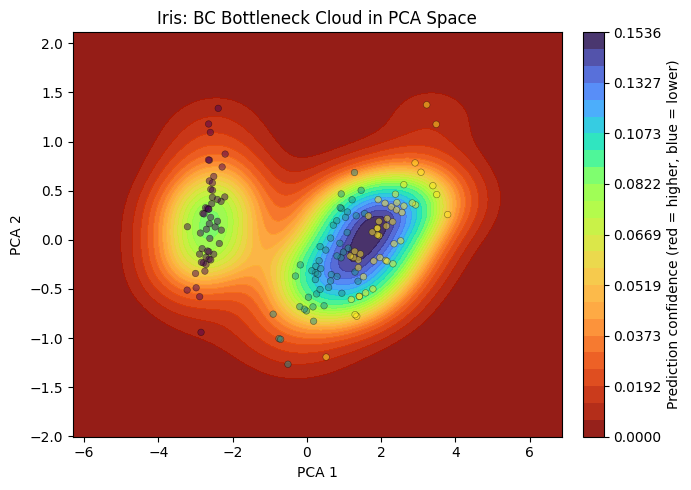

In [107]:
import seaborn as sns
from sklearn.decomposition import PCA

def bc_weights_from_explanation(explanation, X_df, top_k=10):
    nm = explanation.node_metrics.copy()
    nm = nm[nm["Label"].str.contains(r"(<=|>)", regex=True, na=False)].copy()
    top_bc = nm.sort_values("Betweenness centrality", ascending=False).head(top_k)

    weights = np.zeros(len(X_df), dtype=float)

    for _, row in top_bc.iterrows():
        parsed = re.search(r"(.+?)\s*(<=|>)\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", str(row["Label"]))
        if not parsed:
            continue
        feature = parsed.group(1).strip()
        op = parsed.group(2)
        threshold = float(parsed.group(3))
        if feature not in X_df.columns:
            continue

        vals = X_df[feature].values
        vals = np.where(np.isfinite(vals), vals, np.nan)
        if op == '<=':
            weights += (vals <= threshold)
        else:
            weights += (vals > threshold)

    if weights.max() > 0:
        weights = weights / weights.max()
    return weights


def pca_kde_plot(X_df, y, weights, title):
    X_clean = X_df.replace([np.inf, -np.inf], np.nan)
    valid_mask = ~X_clean.isna().any(axis=1)
    X_valid = X_clean[valid_mask]
    y_valid = y[valid_mask]
    w_valid = weights[valid_mask]

    pca = PCA(n_components=2, random_state=27)
    X_pca = pca.fit_transform(X_valid)

    fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor='white')
    ax.set_facecolor('#f6d6d6')

    kde = sns.kdeplot(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        weights=w_valid,
        fill=True,
        levels=25,
        cmap='turbo_r',
        alpha=0.9,
        thresh=0.0,
        bw_adjust=1.15,
        ax=ax,
    )

    ax.scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=y_valid,
        cmap='viridis',
        s=22,
        alpha=0.5,
        edgecolor='k',
        linewidth=0.4,
    )

    cbar = fig.colorbar(kde.collections[0], ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Prediction confidence (red = higher, blue = lower)')

    ax.set_title(title)
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    plt.tight_layout()
    plt.show()


weights = bc_weights_from_explanation(explanation, X, top_k=10)
pca_kde_plot(X, y, weights, 'Iris: BC Bottleneck Cloud in PCA Space')



## 8. Communities (Decision Themes + Class Complexity)

Beyond visualization, we quantify class complexity with class-vs-feature predicate counts:
- Heatmap (absolute counts): how many predicates involving each feature can reach each class node
- Heatmap (row-normalized): per-class feature distribution
- Bar plots: predicate volume and unique feature coverage per class


In [ ]:
# Communities overview + complexity-oriented class-feature analysis
import seaborn as sns
import networkx as nx

explanation.communities.keys()
explanation.communities.get("Communities", [])[:3]

run_name = "iris_dpg"
explainer.plot(run_name, explanation, save_dir="results", class_flag=True, export_pdf=True)
explainer.plot_communities(run_name, explanation, save_dir="results", class_flag=True, export_pdf=True)


def parse_predicate_parts(label):
    m = re.search(r"(.+?)\s*(<=|>)\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", str(label))
    if not m:
        return None
    return m.group(1).strip(), m.group(2), float(m.group(3))


def _resolve_graph_node(G, candidate):
    if candidate in G:
        return candidate
    c = str(candidate)
    for n in G.nodes:
        if str(n) == c:
            return n
    return None


def class_feature_predicate_counts(explanation):
    nm = explanation.node_metrics.copy()
    if 'Node' not in nm.columns or 'Label' not in nm.columns:
        raise ValueError('node_metrics must contain Node and Label columns')

    G = getattr(explanation, 'graph', None)
    if G is None:
        raise ValueError('explanation.graph is required for class-path analysis')

    node_to_label = {str(n): str(lbl) for n, lbl in zip(nm['Node'], nm['Label'])}
    class_df = nm[nm['Label'].astype(str).str.startswith('Class ')].copy()
    if class_df.empty:
        raise ValueError('No class nodes found (labels starting with "Class ")')

    class_feature_counts = {}
    for _, row in class_df.iterrows():
        class_node = _resolve_graph_node(G, row['Node'])
        if class_node is None:
            continue

        class_name = str(row['Label']).replace('Class ', '', 1)
        ancestors = nx.ancestors(G, class_node)

        feats = []
        for anc in ancestors:
            parsed = parse_predicate_parts(node_to_label.get(str(anc), ''))
            if parsed is None:
                continue
            feat, _, _ = parsed
            feats.append(feat)

        class_feature_counts[class_name] = pd.Series(feats).value_counts()

    if not class_feature_counts:
        return pd.DataFrame()

    heat = pd.DataFrame(class_feature_counts).T.fillna(0).astype(int)
    heat = heat.loc[:, heat.sum(axis=0).sort_values(ascending=False).index]
    return heat


def plot_class_feature_complexity(heat_df, dataset_name='Iris', top_n_features=15):
    if heat_df.empty:
        print(f'{dataset_name}: no class-feature predicate counts available.')
        return

    h = heat_df.copy()
    if h.shape[1] > top_n_features:
        h = h.iloc[:, :top_n_features]

    h_norm = h.div(h.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

    fig, axes = plt.subplots(1, 2, figsize=(18, max(5, 0.6 * len(h.index) + 2)))

    sns.heatmap(
        h,
        annot=True,
        fmt='d',
        cmap='YlOrRd',
        linewidths=0.4,
        linecolor='white',
        ax=axes[0],
    )
    axes[0].set_title(f'{dataset_name}: Class vs Feature predicate counts')
    axes[0].set_xlabel('Feature')
    axes[0].set_ylabel('Class')

    sns.heatmap(
        h_norm,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        linewidths=0.4,
        linecolor='white',
        ax=axes[1],
    )
    axes[1].set_title(f'{dataset_name}: Row-normalized feature share by class')
    axes[1].set_xlabel('Feature')
    axes[1].set_ylabel('Class')

    plt.tight_layout()
    plt.show()

    complexity = pd.DataFrame({
        'total_predicates': h.sum(axis=1),
        'unique_features': (h > 0).sum(axis=1),
    }).sort_values('total_predicates', ascending=False)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.barplot(
        x=complexity.index,
        y=complexity['total_predicates'],
        palette='Reds_r',
        ax=axes[0],
    )
    axes[0].set_title(f'{dataset_name}: Predicate volume by class')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Total predicate count')

    sns.barplot(
        x=complexity.index,
        y=complexity['unique_features'],
        palette='Blues_r',
        ax=axes[1],
    )
    axes[1].set_title(f'{dataset_name}: Feature coverage by class')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Unique features in predicates')

    plt.tight_layout()
    plt.show()


heat = class_feature_predicate_counts(explanation)
plot_class_feature_complexity(heat, dataset_name='Iris', top_n_features=15)



def _community_node_sets(explanation, G, node_df):
    comm = getattr(explanation, 'communities', None)
    if not comm:
        return []

    # Accept both {'Communities': [...] } and {'Clusters': {...}} layouts
    if isinstance(comm, dict) and 'Communities' in comm:
        communities = comm.get('Communities', [])
    elif isinstance(comm, dict) and 'Clusters' in comm:
        communities = list(comm.get('Clusters', {}).values())
    else:
        communities = []

    # Label-to-node fallback in case community entries are labels instead of node ids
    label_to_nodes = {}
    for _, r in node_df.iterrows():
        label_to_nodes.setdefault(str(r['Label']), []).append(r['Node'])

    out = []
    for c in communities:
        resolved = set()
        for item in c:
            n = _resolve_graph_node(G, item)
            if n is not None:
                resolved.add(n)
                continue

            # fallback: interpret as label
            for cand in label_to_nodes.get(str(item), []):
                n2 = _resolve_graph_node(G, cand)
                if n2 is not None:
                    resolved.add(n2)

        if resolved:
            out.append(resolved)

    return out


def classwise_feature_bounds_from_communities(explanation):
    nm = explanation.node_metrics.copy()
    G = getattr(explanation, 'graph', None)
    if G is None:
        raise ValueError('explanation.graph is required')

    class_df = nm[nm['Label'].astype(str).str.startswith('Class ')].copy()
    if class_df.empty:
        raise ValueError('No class nodes found')

    class_nodes = {}
    for _, r in class_df.iterrows():
        n = _resolve_graph_node(G, r['Node'])
        if n is not None:
            class_nodes[n] = str(r['Label']).replace('Class ', '', 1)

    pred = nm.copy()
    pred['parsed'] = pred['Label'].apply(parse_predicate_parts)
    pred = pred[pred['parsed'].notna()].copy()

    pred_node_lookup = {}
    for _, r in pred.iterrows():
        n = _resolve_graph_node(G, r['Node'])
        if n is None:
            continue
        feature, op, threshold = r['parsed']
        pred_node_lookup[n] = (str(feature), str(op), float(threshold))

    comm_sets = _community_node_sets(explanation, G, nm)
    if not comm_sets:
        print('No resolved communities found; falling back to all predicate nodes.')
        comm_sets = [set(pred_node_lookup.keys())]

    # Collect predicate thresholds per (class, community, feature)
    bucket = {}
    for ci, nodes in enumerate(comm_sets):
        for n in nodes:
            if n not in pred_node_lookup:
                continue
            feature, op, threshold = pred_node_lookup[n]

            desc = nx.descendants(G, n)
            reachable_classes = [class_nodes[c] for c in class_nodes if c in desc]
            if not reachable_classes:
                continue

            for cls in reachable_classes:
                key = (cls, ci, feature)
                bucket.setdefault(key, {'gt': [], 'le': [], 'all': []})
                if op == '>':
                    bucket[key]['gt'].append(threshold)
                elif op == '<=':
                    bucket[key]['le'].append(threshold)
                bucket[key]['all'].append(threshold)

    rows = []
    for (cls, ci, feature), vals in bucket.items():
        raw_min = min(vals['all'])
        raw_max = max(vals['all'])
        lower = max(vals['gt']) if vals['gt'] else raw_min
        upper = min(vals['le']) if vals['le'] else raw_max

        # Guard against inconsistent constraints in noisy communities
        if lower > upper:
            lower, upper = raw_min, raw_max

        rows.append({
            'class_name': cls,
            'community_id': ci,
            'feature': feature,
            'lower_bound': float(lower),
            'upper_bound': float(upper),
            'range_width': float(upper - lower),
        })

    if not rows:
        return pd.DataFrame(columns=['class_name', 'community_id', 'feature', 'lower_bound', 'upper_bound', 'range_width'])

    return pd.DataFrame(rows)


def plot_classwise_feature_ranges(bounds_df, dataset_name='Iris', top_features=4):
    if bounds_df.empty:
        print(f'{dataset_name}: no classwise feature bounds from communities available.')
        return

    # Aggregate community-level bounds into class-level representation
    class_bounds = (
        bounds_df.groupby(['class_name', 'feature'], as_index=False)
        .agg(
            lower_bound=('lower_bound', 'min'),
            upper_bound=('upper_bound', 'max'),
            community_support=('community_id', 'nunique'),
        )
    )
    class_bounds['range_width'] = class_bounds['upper_bound'] - class_bounds['lower_bound']

    classes = sorted(class_bounds['class_name'].unique())
    n = len(classes)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), squeeze=False)
    axes = axes[0]

    for ax, cls in zip(axes, classes):
        cdf = class_bounds[class_bounds['class_name'] == cls].copy()
        # Rank features by community support then by range width
        cdf = cdf.sort_values(['community_support', 'range_width'], ascending=[False, False]).head(top_features)
        cdf = cdf.sort_values('range_width', ascending=True)

        y = np.arange(len(cdf))
        ax.hlines(y, cdf['lower_bound'], cdf['upper_bound'], color='tab:blue', linewidth=3, alpha=0.8)
        ax.scatter(cdf['lower_bound'], y, color='tab:green', s=35, label='min bound' if cls == classes[0] else None)
        ax.scatter(cdf['upper_bound'], y, color='tab:red', s=35, label='max bound' if cls == classes[0] else None)

        ax.set_yticks(y)
        ax.set_yticklabels(cdf['feature'])
        ax.set_xlabel('Feature value range from community predicates')
        ax.set_title(f'{dataset_name} — Class {cls} range summary')
        ax.grid(axis='x', linestyle='--', alpha=0.35)

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='lower center', ncol=2, frameon=True)
    plt.tight_layout(rect=(0, 0.08, 1, 1))
    plt.show()

    # Optional compact heatmap: average range width per class-feature
    width_pivot = (
        class_bounds.pivot_table(index='class_name', columns='feature', values='range_width', fill_value=0.0)
        .loc[:, lambda d: d.mean(axis=0).sort_values(ascending=False).index]
    )

    plt.figure(figsize=(max(8, 0.6 * width_pivot.shape[1] + 3), max(3.5, 0.7 * width_pivot.shape[0] + 2)))
    sns.heatmap(width_pivot, annot=True, fmt='.2f', cmap='PuBuGn', linewidths=0.4, linecolor='white')
    plt.title(f'{dataset_name}: class-feature range width (community-derived)')
    plt.xlabel('Feature')
    plt.ylabel('Class')
    plt.tight_layout()
    plt.show()


# New plot: class representation using min/max feature bounds from communities
class_bounds = classwise_feature_bounds_from_communities(explanation)
plot_classwise_feature_ranges(class_bounds, dataset_name='Iris', top_features=4)



def _class_lookup_from_target_names(target_names):
    if target_names is None:
        return {}
    return {str(name): i for i, name in enumerate(list(target_names))}


def _class_mask(class_name, y, class_lookup=None):
    # 1) Direct lookup (e.g., {'setosa': 0, ...})
    if class_lookup and str(class_name) in class_lookup:
        return (y == class_lookup[str(class_name)])

    # 2) Numeric class names
    try:
        as_int = int(class_name)
        return (y == as_int)
    except Exception:
        pass

    # 3) String labels in y
    return (pd.Series(y).astype(str).values == str(class_name))


def dataset_feature_bounds_by_class(X_df, y, class_names, class_lookup=None):
    rows = []
    for cls in class_names:
        mask = _class_mask(cls, y, class_lookup=class_lookup)
        Xc = X_df.loc[mask]
        if Xc.empty:
            continue
        for f in X_df.columns:
            rows.append({
                'class_name': str(cls),
                'feature': str(f),
                'ds_lower_bound': float(Xc[f].min()),
                'ds_upper_bound': float(Xc[f].max()),
            })
    return pd.DataFrame(rows)


def plot_dpg_vs_dataset_feature_ranges(class_bounds, X_df, y, dataset_name='Iris', top_features=4, class_lookup=None):
    if class_bounds.empty:
        print(f'{dataset_name}: class bounds are empty.')
        return

    # Same aggregated class-level DPG bounds used in the class range summary plot
    dpg_bounds = (
        class_bounds.groupby(['class_name', 'feature'], as_index=False)
        .agg(
            lower_bound=('lower_bound', 'min'),
            upper_bound=('upper_bound', 'max'),
            community_support=('community_id', 'nunique'),
        )
    )
    dpg_bounds['range_width'] = dpg_bounds['upper_bound'] - dpg_bounds['lower_bound']

    classes = sorted(dpg_bounds['class_name'].unique())
    ds_bounds = dataset_feature_bounds_by_class(X_df, y, classes, class_lookup=class_lookup)

    n = len(classes)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), squeeze=False)
    axes = axes[0]

    for ax, cls in zip(axes, classes):
        cdf = dpg_bounds[dpg_bounds['class_name'] == cls].copy()
        cdf = cdf.sort_values(['community_support', 'range_width'], ascending=[False, False]).head(top_features)
        cdf = cdf.sort_values('range_width', ascending=True)

        merged = cdf.merge(
            ds_bounds[ds_bounds['class_name'] == cls],
            on=['class_name', 'feature'],
            how='left',
        )

        y_pos = np.arange(len(merged))

        # Dataset ranges (reference) in gray
        ax.hlines(y_pos, merged['ds_lower_bound'], merged['ds_upper_bound'],
                  color='lightgray', linewidth=6, alpha=0.8, label='dataset class range' if cls == classes[0] else None)
        ax.scatter(merged['ds_lower_bound'], y_pos, color='dimgray', s=28,
                   label='dataset min/max' if cls == classes[0] else None)
        ax.scatter(merged['ds_upper_bound'], y_pos, color='dimgray', s=28)

        # DPG community-derived ranges in blue
        ax.hlines(y_pos, merged['lower_bound'], merged['upper_bound'],
                  color='tab:blue', linewidth=3, alpha=0.95, label='DPG community range' if cls == classes[0] else None)
        ax.scatter(merged['lower_bound'], y_pos, color='tab:green', s=38,
                   label='DPG min bound' if cls == classes[0] else None)
        ax.scatter(merged['upper_bound'], y_pos, color='tab:red', s=38,
                   label='DPG max bound' if cls == classes[0] else None)

        ax.set_yticks(y_pos)
        ax.set_yticklabels(merged['feature'])
        ax.set_xlabel('Feature value range')
        ax.set_title(f'{dataset_name} — Class {cls}: DPG vs dataset range')
        ax.grid(axis='x', linestyle='--', alpha=0.35)

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='lower center', ncol=3, frameon=True)

    plt.tight_layout(rect=(0, 0.10, 1, 1))
    plt.show()


# New comparison chart: DPG class ranges vs dataset class min/max ranges
class_lookup = _class_lookup_from_target_names(iris.target_names if 'iris' in globals() else None)
plot_dpg_vs_dataset_feature_ranges(
    class_bounds,
    X,
    y,
    dataset_name='Iris',
    top_features=4,
    class_lookup=class_lookup,
)



## 9. What to Say in the Story
Use these points for a concise practitioner summary:
- **LRC:** Which predicate most strongly frames the model’s logic?
- **RF importance:** Which features dominate split quality in the forest?
- **BC cloud:** Where bottleneck predicates concentrate in PCA space?
- **Communities + complexity:** Which classes rely on broader/more concentrated feature predicate sets?


## Next Episode
We will move to another scikit-learn benchmark dataset.
